# CIFAR10 and Transfer Learning

## CIFAR10

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_data = dsets.CIFAR10(root='./data', 
                           train=True,
                           download=True, 
                           transform=transforms.ToTensor())

test_data  = dsets.CIFAR10(root='./data', 
                           train=False,
                           download=True, 
                           transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [4]:
batch_size = 128

train_loader = DataLoader(train_data, 
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_data, 
                         batch_size=5,
                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

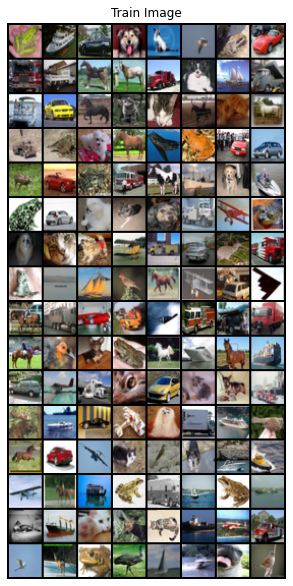

In [6]:
train_iter = iter(train_loader)
images, labels = train_iter.next()

imshow(images, "Train Image")

In [7]:
images.shape

torch.Size([128, 3, 32, 32])

## Train and Evaluate CNN

### Train CNN

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(64*5*5, 100),
            nn.ReLU(),
            nn.Linear(100, 10)              
        )
        
    def forward(self, x):
        out = self.conv_layer(x)
        out = out.view(-1, 64*5*5)
        out = self.fc_layer(out)
        
        return out
    
model = CNN().cuda()

In [9]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [10]:
num_epochs = 10

In [11]:
for epoch in range(num_epochs):

    total_batch = len(train_data) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/10], lter [200/390], Loss: 2.2994
Epoch [2/10], lter [200/390], Loss: 2.2048
Epoch [3/10], lter [200/390], Loss: 2.0511
Epoch [4/10], lter [200/390], Loss: 1.9134
Epoch [5/10], lter [200/390], Loss: 1.9295
Epoch [6/10], lter [200/390], Loss: 1.7474
Epoch [7/10], lter [200/390], Loss: 1.5501
Epoch [8/10], lter [200/390], Loss: 1.4293
Epoch [9/10], lter [200/390], Loss: 1.6325
Epoch [10/10], lter [200/390], Loss: 1.3674


### Evalute Model

In [12]:
correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 47.010000 %


Predicted:    cat  ship  ship  ship  deer


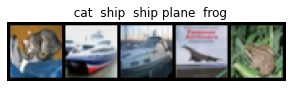

In [13]:
images, labels = iter(test_loader).next()
outputs = model(images.cuda())

_, predicted = torch.max(outputs.data, 1)
    
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(5)))

title = (' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(images, title)

## Train and Evaluate Developed CNN

### Preprocessing Data

In [14]:
transform = transforms.Compose([
    # Data Augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(32),
    
    # Data Nomalization
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Normalize a tensor image with mean and standard deviation.
# Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels,
# this transform will normalize each channel of the input torch.
# *Tensor i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]

train_data = dsets.CIFAR10(root='./data', 
                           train=True,
                           download=True, 
                           transform=transform)

test_data  = dsets.CIFAR10(root='./data', 
                           train=False,
                           download=True, 
                           transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
batch_size = 128

train_loader = DataLoader(train_data, 
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_data, 
                         batch_size=batch_size,
                         shuffle=False)

### Train CNN

In [16]:
import torch.nn.init as init

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            
            # Batch Nomalization
            nn.BatchNorm2d(32),
            
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 5),
            
            # Batch Nomalization
            nn.BatchNorm2d(64),
            
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 5 * 5, 100),
            # Dropout
            # nn.Dropout(0.5)
            nn.ReLU(),
            nn.Linear(100, 10)              
        )
        
        # Weight Initialization
        for m in self.modules() :
            if isinstance(m, nn.Conv2d):
                # init.xavier_normal(m.weight.data)
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)      
            if isinstance(m, nn.Linear):
                # init.xavier_normal(m.weight.data)
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)                
        
    def forward(self, x):
        out = self.conv_layer(x)
        out = out.view(-1, 64*5*5)
        out = self.fc_layer(out)
        
        return out
    
model = CNN().cuda()

In [18]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Momentum & Weight Regularization(L2)
# optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-5)

In [19]:
num_epochs = 10

In [20]:
for epoch in range(num_epochs):

    total_batch = len(train_data) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/10], lter [200/390], Loss: 1.3701
Epoch [2/10], lter [200/390], Loss: 0.9935
Epoch [3/10], lter [200/390], Loss: 0.8844
Epoch [4/10], lter [200/390], Loss: 0.8606
Epoch [5/10], lter [200/390], Loss: 0.6666
Epoch [6/10], lter [200/390], Loss: 0.8969
Epoch [7/10], lter [200/390], Loss: 0.7463
Epoch [8/10], lter [200/390], Loss: 0.6370
Epoch [9/10], lter [200/390], Loss: 0.7205
Epoch [10/10], lter [200/390], Loss: 0.7905


### Eval Developed CNN

In [21]:
# 이제부터는 꼭 해주어야함.
# Batch Norm과 Dropout은 Train과 Test일 때 서로 다르게 행동함.
model.eval()

# 반대로 다시 Train을 해야하면
# model.train()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 72.570000 %


## Trnasfer Learning

In [22]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(277),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((277, 277)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [23]:
train_data = dsets.CIFAR10(root='./data', 
                           train=True,
                           download=True, 
                           transform=transforms.ToTensor())

test_data  = dsets.CIFAR10(root='./data', 
                           train=False,
                           download=True, 
                           transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [24]:
batch_size = 128

train_loader = DataLoader(train_data, 
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_data, 
                         batch_size=batch_size,
                         shuffle=False)

In [39]:
model = torchvision.models.vgg16(pretrained=True).cuda()

In [40]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [41]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [42]:
# for parameter in model.parameters():
#     parameter.requires_grad = False
model.classifier[-1] = nn.Linear(in_features=4096, out_features=10, bias=True).cuda()

# model.classifier[-1] = nn.Sequantial(
#     nn.Linear(in_features=4096, out_features=512, bias=True),
#     nn.ReLU(),
#     nn.Linear(in_features=512, out_features=10, bias=True),
# ).cuda()

In [43]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Momentum & Weight Regularization(L2)
# optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-5)

In [44]:
num_epochs = 10

In [45]:
model.train()

for epoch in range(num_epochs):

    total_batch = len(train_data) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/10], lter [200/390], Loss: 0.4426
Epoch [2/10], lter [200/390], Loss: 0.3261
Epoch [3/10], lter [200/390], Loss: 0.2458
Epoch [4/10], lter [200/390], Loss: 0.1556
Epoch [5/10], lter [200/390], Loss: 0.0399
Epoch [6/10], lter [200/390], Loss: 0.0374
Epoch [7/10], lter [200/390], Loss: 0.0604
Epoch [8/10], lter [200/390], Loss: 0.0091
Epoch [9/10], lter [200/390], Loss: 0.1321
Epoch [10/10], lter [200/390], Loss: 0.0172


In [46]:
model.eval()
correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 87.860000 %
